# Udacity Self-Driving Car Engineer Nanodegree Program

## Vehicle Detection Project

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Load dataset

For the project the training dataset ([vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) images) provided  was used. The extraction of the data is done below.

In [1]:
import glob

In [2]:
car_files = glob.glob('vehicles/**/*.png')
noncar_files = glob.glob('non-vehicles/**/*.png')

print('The dataset consists of {} car and {} non-car images'.format(len(car_files), len(noncar_files)))

The dataset consists of 8792 car and 8968 non-car images


In [3]:
import numpy as np
import matplotlib.image as mpimg
import cv2
%matplotlib inline

In [4]:
car_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in car_files]
noncar_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in noncar_files]

In [5]:
example_img = car_imgs[np.random.randint(0, len(car_imgs))]
print('The shape of the images is: {}'.format(example_img.shape))
print("The min value is {} and the max value of the image is {}".format(np.amin(example_img),
                                                                     np.amax(example_img)))

The shape of the images is: (64, 64, 3)
The min value is 9 and the max value of the image is 255


### Visualize data

In [6]:
import matplotlib.pyplot as plt


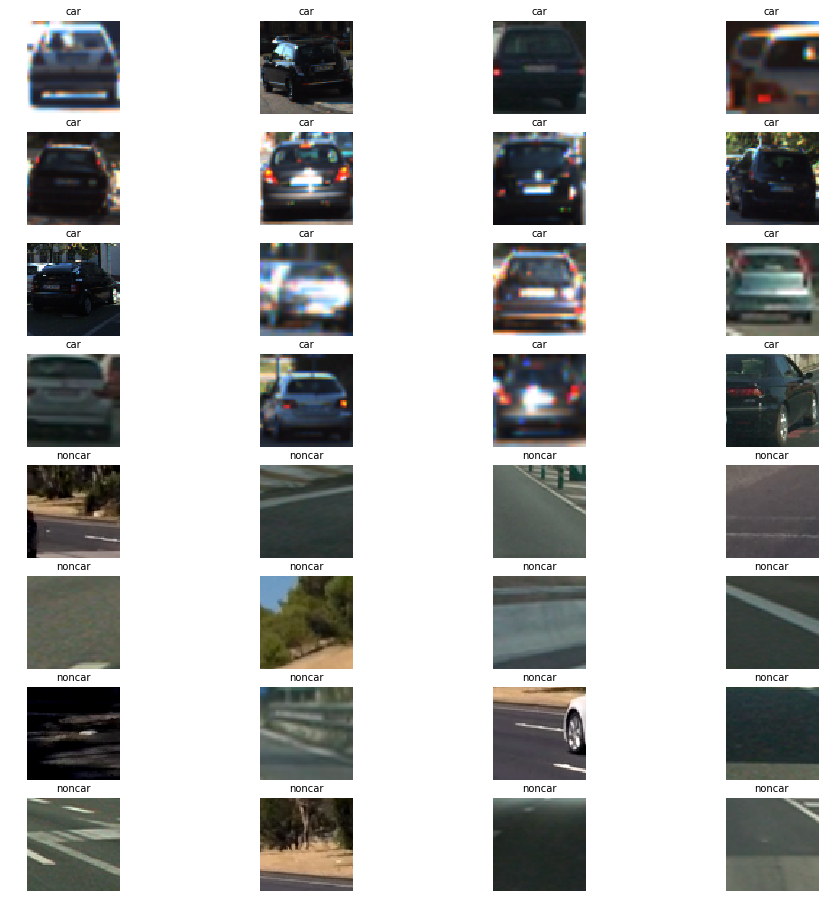

In [7]:
fig, axis = plt.subplots(8, 4, figsize=(16,16))
axis = axis.ravel()

for i in np.arange(32):
    if i < 16:
        axis[i].imshow(car_imgs[np.random.randint(0, len(car_imgs))])
        axis[i].set_title('car', fontsize=10)
        axis[i].axis('off')
    else:
        axis[i].imshow(noncar_imgs[np.random.randint(0, len(noncar_imgs))])
        axis[i].set_title('noncar', fontsize=10)
        axis[i].axis('off')

### HOG Classify

In this section a function will be defined in order to get the Histogram of Oriented Gradients (HOG) from the images. The function is already defined during the lesson and it will be used as is.

In [8]:
from skimage.feature import hog

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    """
    Define a function to return HOG features
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

And here is an example of two images of the dataset (car and noncar) with the respective HOG feature map

(-0.5, 63.5, 63.5, -0.5)

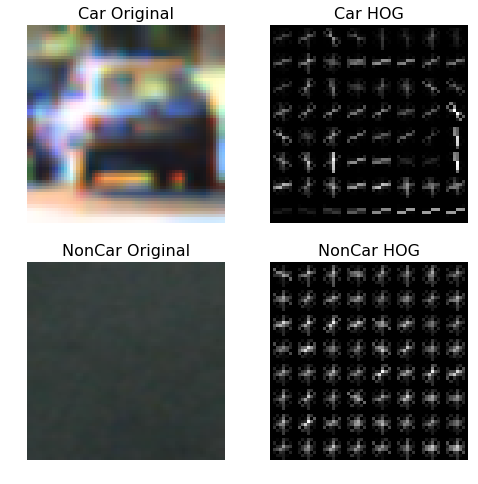

In [10]:
car_img = car_imgs[np.random.randint(0, len(car_imgs))]
noncar_img = noncar_imgs[np.random.randint(0, len(noncar_imgs))]

# Convert to grayscale
gray_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
gray_noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2

# Call the function with vis=True to see an image output
car_feat, car_hog_img = get_hog_features(gray_car_img, orient, pix_per_cell, 
                                         cell_per_block, vis=True, feature_vec=False)
noncar_fear, noncar_hog_img = get_hog_features(gray_noncar_img, orient, pix_per_cell, 
                                         cell_per_block, vis=True, feature_vec=False)

# Visualize
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,8))
ax1.imshow(car_img)
ax1.set_title('Car Original', fontsize=16)
ax1.axis('off')
ax2.imshow(car_hog_img, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax2.axis('off')
ax3.imshow(noncar_img)
ax3.set_title('NonCar Original', fontsize=16)
ax3.axis('off')
ax4.imshow(noncar_hog_img, cmap='gray')
ax4.set_title('NonCar HOG', fontsize=16)
ax4.axis('off')


### Color Histogram and Spatial Binning

We are going to use two more functions for the lesson that are going to help us in the classification of the images
* `bin_spatial` which computes the binned color features of the images and
* `color_hist` which computes the color histogram features of the image

In [11]:
def bin_spatial(img, size=(32, 32)):
    """
    Function that computes binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Function that computes the color histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

Let's visualize for example the spatial binning first of the previous car and non-car images

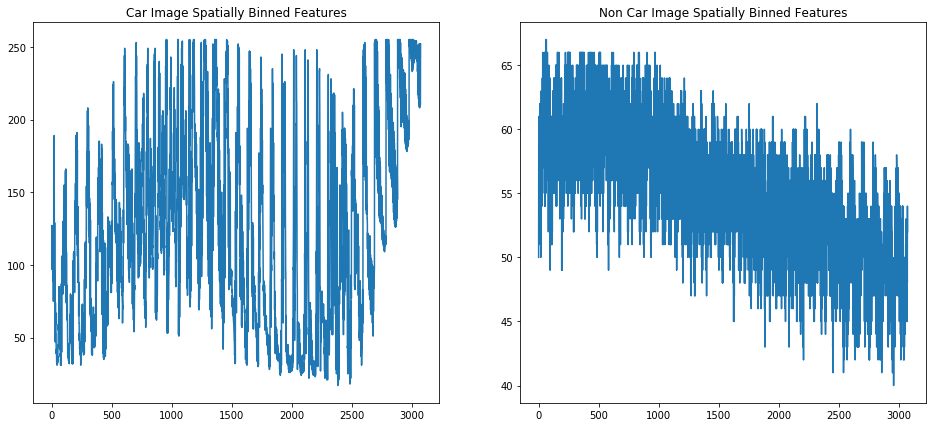

In [12]:
feature_car_img = np.copy(car_img)
feature_noncar_img = np.copy(noncar_img)

# Apply spatial binning
car_feature_vec = bin_spatial(feature_car_img)
noncar_feature_vec = bin_spatial(feature_noncar_img)

# Plot features
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
ax1.plot(car_feature_vec)
ax1.set_title('Car Image Spatially Binned Features')
ax2.plot(noncar_feature_vec)
ax2.set_title('Non Car Image Spatially Binned Features')

### Extract Features

After we defined the methods to identify features the next step was to create a method in order to combine all of them and create a normalized feature map. The method `extract_features` does this thing.

In [13]:
def extract_features(image, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=8,
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Function to extract features from a list
    of images
    """
    # Create a list to append feature vectors to
    features = []
    file_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    if spatial_feat == True:
        # Apply bin_spatial to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    return np.concatenate((spatial_features, hist_features, hog_features))

After defining the function we are ready to tune some hyperparameters in order to extract the necessary features of the images. Some of the important parameters are:

* The colorspace (RGB, YUV, HLS, etc.)
* The HOG parameters:
    * orientation
    * pixels per cell
    * cells per block
    * channel on which the HOG is applied
* Spatial size
* Histogram bins etc.
    
As in lesson we gonna keep track of the time needed in order to finish the feature extraction.

In [14]:
# Feature extraction hyperparameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
sptl_size = (16,16)
nbins = 32

In [15]:
import time

In [16]:
t1 = time.time()
car_features = [extract_features(car_img, color_space=colorspace, spatial_size=sptl_size, hist_bins=nbins, 
                               orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                               hog_channel=hog_channel) for car_img in car_imgs]
noncar_features = [extract_features(noncar_img, color_space=colorspace, spatial_size=sptl_size, hist_bins=nbins,
                                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                  hog_channel=hog_channel) for noncar_img in noncar_imgs]
t2 = time.time()

# Find the timing
print(round(t2-t1, 2), 'seconds to extract features')

89.18 seconds to extract features


In [17]:
print('Size of feature vector is', len(car_features[0]))

Size of feature vector is 5568


### Creating the dataset

We are going to try now to create the **train** and **test** datasets. As it was mentioned in lessons it is good to keep track of the amount of positive and negatives on each set. So we are going first to split the *car* and *noncar* sets seperately and then we are going to merge them so we have both sets balanced regarding the amount of positives and negatives. During merge we are going to scale the data.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [19]:
# Create the labels for car and non car features
print(len(car_features), len(noncar_features))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Create dataset
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

# Create random number
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=rand_state)

print('In training dataset we have {} features and {} labels.'.format(len(X_train), len(y_train)))
print('From them {} are car and {} are non-car images.'.format((y_train==1).sum(), (y_train==0).sum()))
print('In test dataset we have {} features and {} labels.'.format(len(X_test), len(y_test)))
print('From them {} are car and {} are non-car images.'.format((y_test==1).sum(), (y_test==0).sum()))


8792 8968
In training dataset we have 14208 features and 14208 labels.
From them 7059 are car and 7149 are non-car images.
In test dataset we have 3552 features and 3552 labels.
From them 1733 are car and 1819 are non-car images.


### Fitting the classifier

As we finished creating the dataset we may proceed in fitting the classifier. We are going to use as proped the `LinearSVC` for the classification task of the images.

In [20]:
from sklearn.svm import LinearSVC

In [21]:
# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'seconds to train SVC...')

# Check accurac score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a predefined a single sample
n_predict = 10
t1=time.time()

print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t1, 5), 'seconds to predict', n_predict, 'labels with SVC')

10.93 seconds to train SVC...
Test Accuracy of SVC =  0.9859
My SVC predicts:      [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00125 seconds to predict 10 labels with SVC


## Finding cars in Images

### Convert color helper function

In [22]:
def convert_color(img, color_space='RGB'):
    """
    Function that converts the colorspace of an image
    """
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Return the color altered image
    return feature_image

### Draw boxes helper function

In [23]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Function that draws rectangles on an image based
    on given bounding boxes array
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Using sliding window on test images

We are going to use the `slide_window` function implemented during lesson in order to search the image and predict the place of cars on the **test_images**. In that way we are going to test if our classifier is working on a good way.

In [24]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [25]:
def find_cars(img, svc, scaler, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, 
              hog_channel, y_start_stop, xy_window, xy_overlap):
    
    bboxes = []
    imwindow_list = []
    window_list = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    
    for window in window_list:
        imwindow = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(imwindow, color_space, spatial_size, hist_bins, orient, 
                                    pix_per_cell, cell_per_block, hog_channel)
        features_scaled = scaler.transform(features.reshape(1, -1))
        prediction = svc.predict(features_scaled)
        if prediction == 1:
            bboxes.append(window)
    return bboxes
    

In [26]:
test_files = glob.glob('test_images/*.jpg')
print(test_files)

['test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test5.jpg', 'test_images/test4.jpg', 'test_images/test2.jpg', 'test_images/test6.jpg']


In [27]:
# Get the test images.
test_imgs = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in test_files]

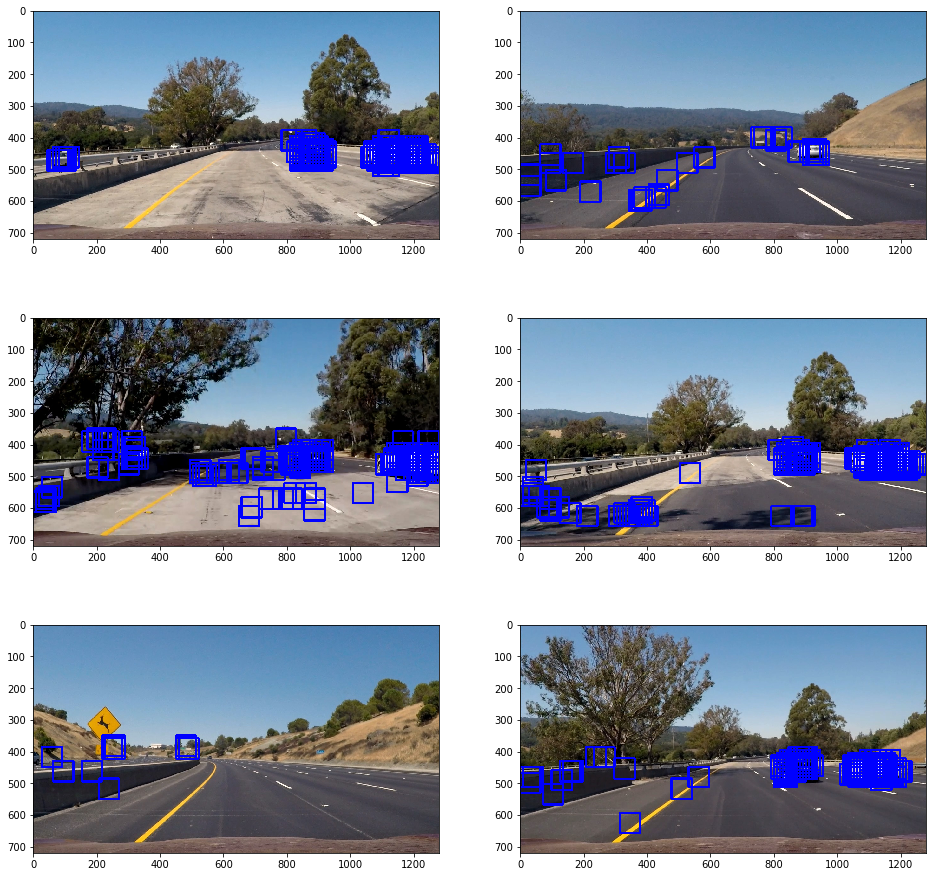

In [28]:
y_start_stop = [350, 656]
xy_window = (64,64)
xy_overlap = (0.85, 0.85)

bboxes = [find_cars(img, svc, X_scaler, colorspace, sptl_size, nbins, orient, pix_per_cell,
                    cell_per_block, hog_channel, y_start_stop, xy_window, xy_overlap)
          for img in test_imgs]

# Draw the bounding boxes
out_imgs = [draw_boxes(img, bbox) for img, bbox in zip(test_imgs,bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()

for i in np.arange(len(test_files)):
    axis[i].imshow(out_imgs[i])

### HOG sub-sampling

Here we implement the function that given the sections of the image is able to detect the cars and return the rectangles where the car is located. The function is taken from the lesson implementation but it is altered in order to return the bounding boxes array which is fed on the `draw_boxes` function.

In [29]:
def find_cars2(img, svc, scaler, spatial_size, hist_bins, orient, pix_per_cell, 
              cell_per_block, y_start_stop, scale):

    bboxes = []
    ystart, ystop = y_start_stop
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.concatenate((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(test_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return bboxes

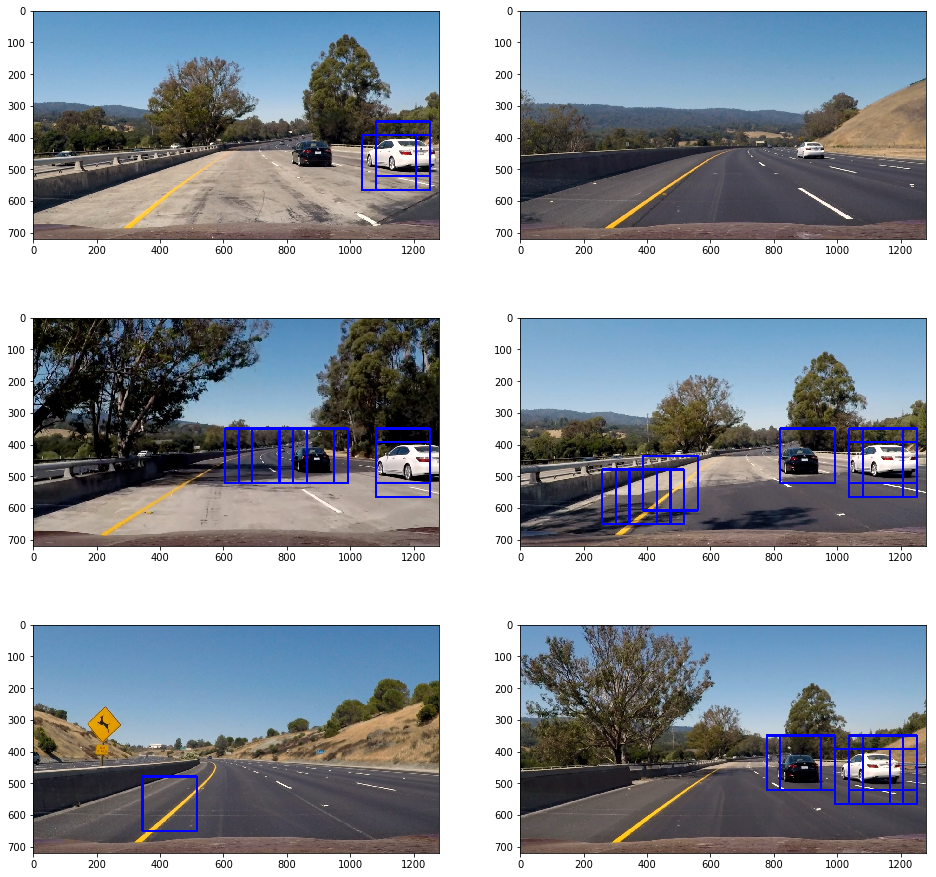

In [30]:
scale = 2.7

bboxes = [find_cars2(img, svc, X_scaler, sptl_size, nbins, orient, pix_per_cell,
                    cell_per_block, y_start_stop, scale)
          for img in test_imgs]

# Draw the bounding boxes
out_imgs = [draw_boxes(img, bbox) for img, bbox in zip(test_imgs,bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()

for i in np.arange(len(test_files)):
    axis[i].imshow(out_imgs[i])

In [31]:
def find_car_windows(img, svc, scaler):
    
    #y_start_stop_list = [[356,4], [436,500], [350,496], [398,526], [350,528], [414,558], [350,592], [446,656]]
    y_start_stop_list = [[356,500], [356,500], [370,550], [356,550], [356,670]]
    #scales = [1.0, 1.0, 1.5, 1.5, 2.0, 2.0, 3.0, 3.0]
    scales = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    sptl_size = (16,16)
    nbins = 32

    bboxes = [find_cars2(img, svc, scaler, sptl_size, nbins, orient, pix_per_cell,
                        cell_per_block, y_start_stop, scale)
              for y_start_stop, scale in zip(y_start_stop_list, scales)]
    
    # Stack Overflow https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
    bboxes = [item for sublist in bboxes for item in sublist]
    
    return bboxes
    
    

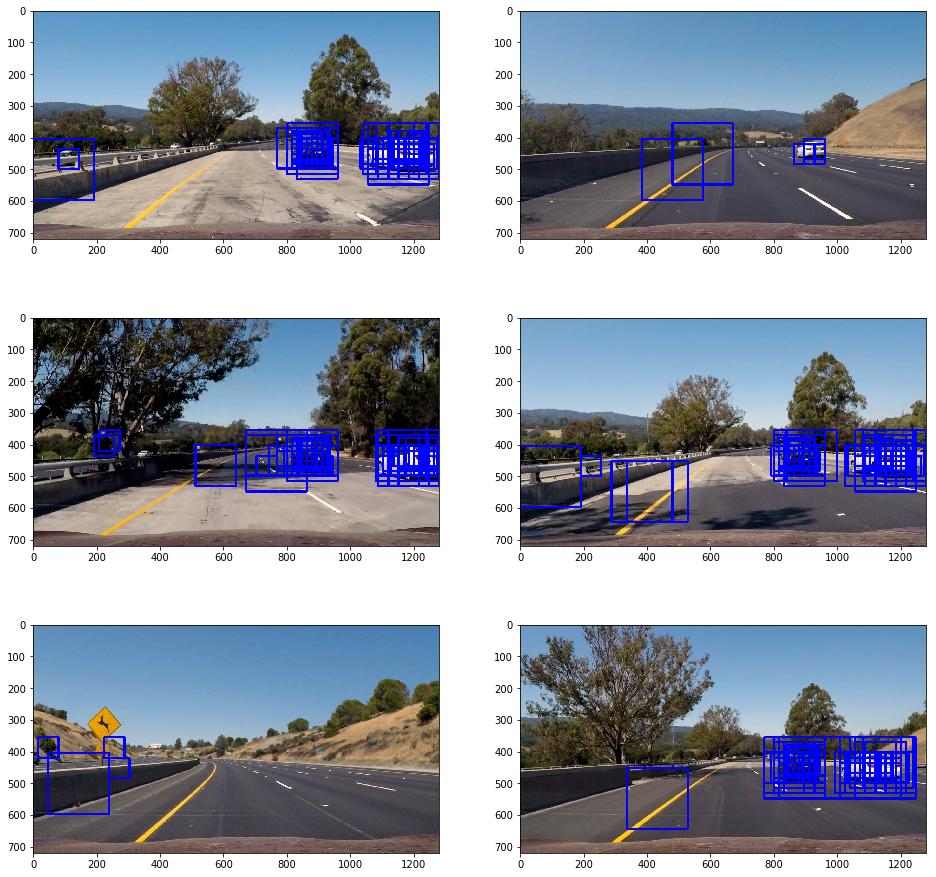

In [32]:
bboxes = [find_car_windows(test_img, svc, None) for test_img in test_imgs]

test_imgs_boxed = [draw_boxes(test_img, bbox) for test_img, bbox in zip(test_imgs, bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(test_imgs_boxed[i])

### Heatmap implementation

We notice that we have enough false positives and in order to get rid of them we are going to apply a heatmap on the images to identify the cars based on the overlap of the bounding boxes

In [33]:
def add_heat(heatmap, bbox_list):
    """
    Function that adds heat based on the bounding boxes
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

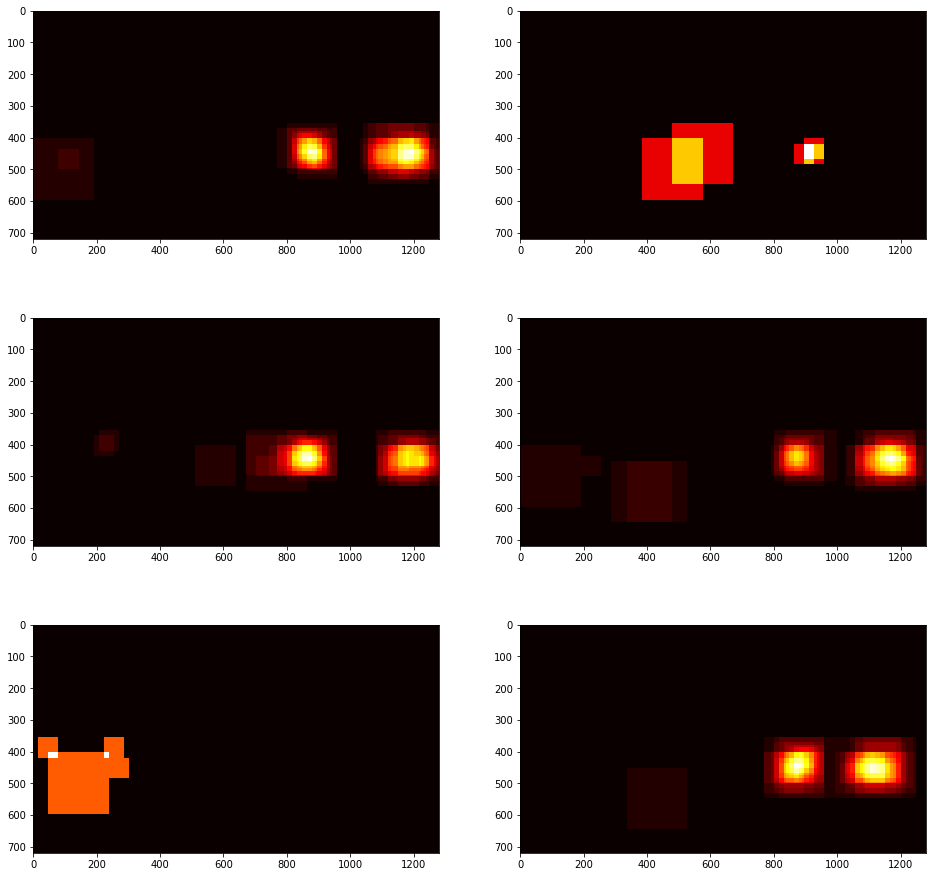

In [34]:
# Visualize heatmaps
heatmap_imgs = [np.zeros_like(img[:,:,0]).astype(np.float) for img in test_imgs]
heatmap_imgs = [add_heat(heatmap_img, bbox) for heatmap_img, bbox in zip(heatmap_imgs, bboxes)]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(heatmap_imgs[i], cmap='hot')

And if we apply a threshold on heatmap then we can identify the cars on the images

In [35]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

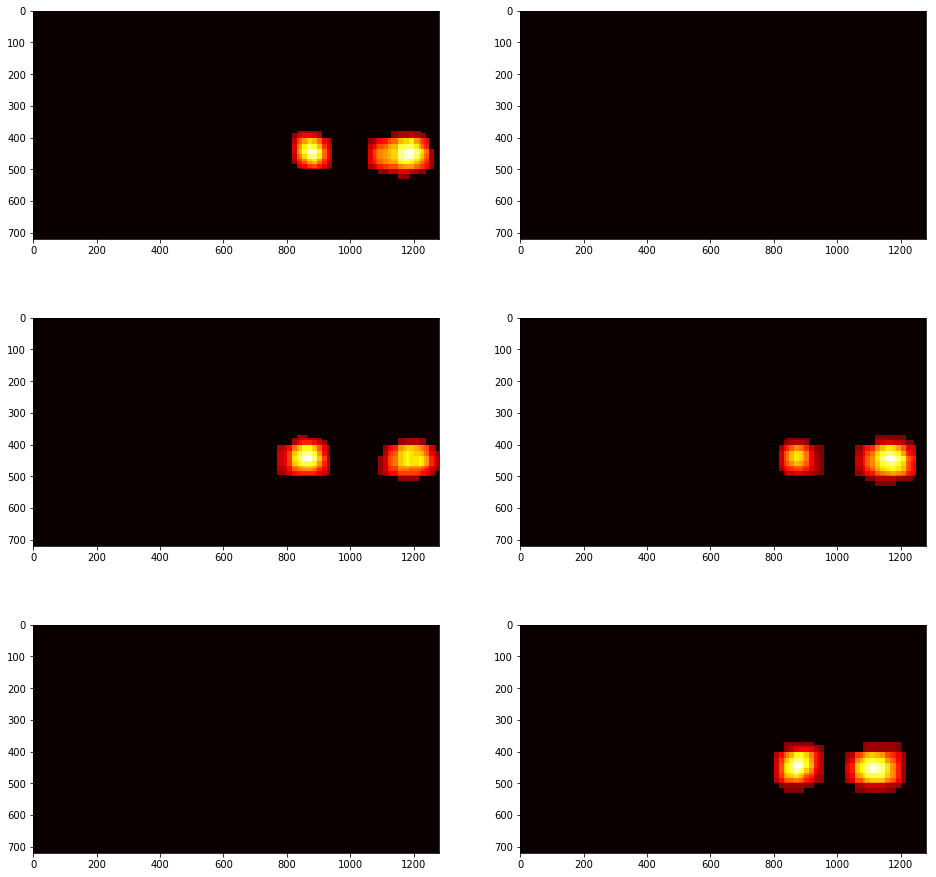

In [36]:
heatmap_imgs = [apply_threshold(heatmap_img, 4) for heatmap_img in heatmap_imgs]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(heatmap_imgs[i], cmap='hot')

Now we need to use the function that draws the labeled boxes from the lesson.

In [37]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

and conclude to the function that merges all the above together:

In [38]:
from scipy.ndimage.measurements import label

In [39]:
def processImages(img, svc, scaler, threshold=1):
    """
    Find the cars on frames
    """
    # 1) Find the bounding boxes
    bboxes = find_car_windows(img, svc, scaler)
    # 2) Create the heatmap
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heatmap_img, bboxes)
    # 3) Apply threshold on heamap
    heat = apply_threshold(heat,threshold)
    # 4) Find final boxes from heatmap using label function
    labels = label(heat)
    # 5) Draw the labeled boxes
    labeled_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return labeled_img

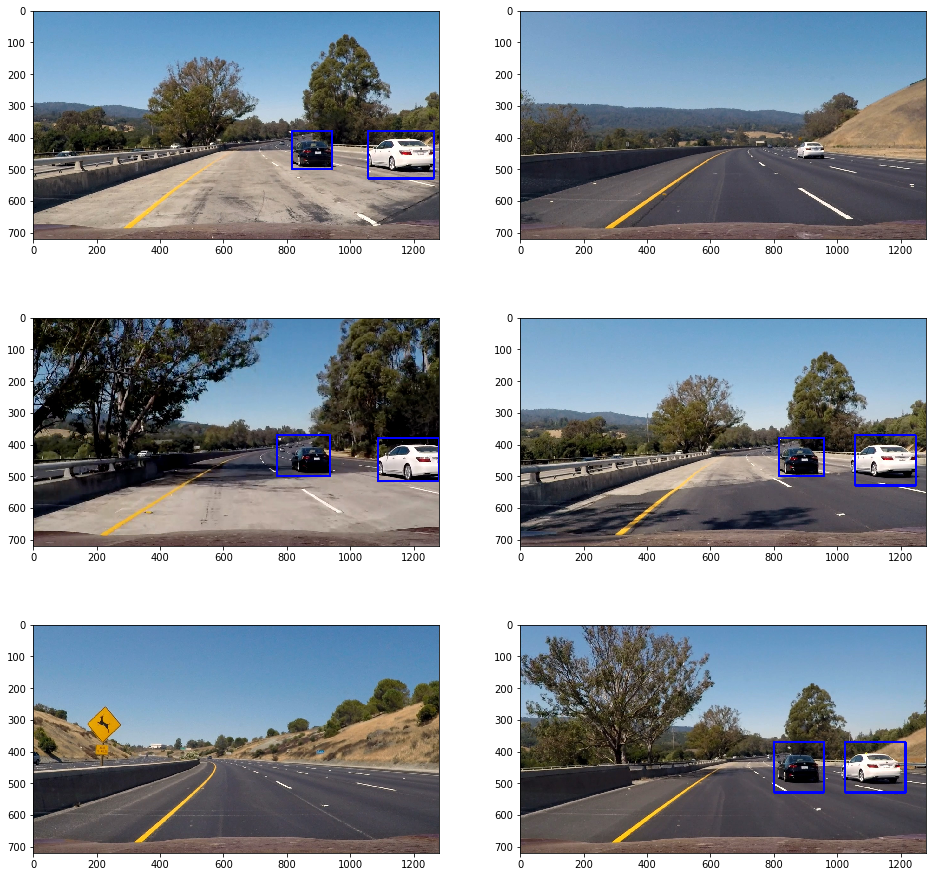

In [40]:
out_imgs = [processImages(img, svc, X_scaler, 4) for img in test_imgs]

# Plot the images
fig, axis = plt.subplots(3, 2, figsize=(16,16))
axis = axis.ravel()
for i in np.arange(len(test_files)):
    axis[i].imshow(out_imgs[i])

## Video pipeline

In [41]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce

In [42]:
from moviepy.editor import VideoFileClip

class VideoProcessor():
    def __init__(self):
        self.heatBuffer = []
        self.framecnt = 4
        self.svc = svc
        self.scaler = X_scaler
        self.threshold = 5
        
    def processFrame(self, img):
        
        # 1) Find the bounding boxes
        bboxes = find_car_windows(img, self.svc, self.scaler)
        # 2) Create the heatmap
        heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heatmap_img, bboxes)
        if len(self.heatBuffer) > self.framecnt:
            self.heatBuffer = self.heatBuffer[1:]
        self.heatBuffer.append(heat)
        heatBuffer = reduce(lambda x, y: x+y, self.heatBuffer)/self.framecnt
        
        # 3) Apply threshold on heamap
        heat = apply_threshold(heatBuffer,self.threshold)
        # 4) Find final boxes from heatmap using label function
        labels = label(heat)
        # 5) Draw the labeled boxes
        labeled_img = draw_labeled_bboxes(np.copy(img), labels)

        return labeled_img

In [43]:
outputpath = "test_videos_output"
if os.path.exists(outputpath) == False:
    os.mkdir(outputpath)
test_output = 'test_videos_output/test_video_output.mp4'
v1Processor = VideoProcessor()
clip1 = VideoFileClip('test_video.mp4')
test_clip = clip1.fl_image(v1Processor.processFrame)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video_output.mp4
[MoviePy] Writing video test_videos_output/test_video_output.mp4


 97%|█████████▋| 38/39 [00:31<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video_output.mp4 

CPU times: user 37.9 s, sys: 168 ms, total: 38.1 s
Wall time: 32.3 s


In [44]:
outputpath = "test_videos_output"
if os.path.exists(outputpath) == False:
    os.mkdir(outputpath)
test_output = 'test_videos_output/project_video_output.mp4'
v2Processor = VideoProcessor()
clip1 = VideoFileClip('project_video.mp4')
test_clip = clip1.fl_image(v2Processor.processFrame)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [17:35<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 22min 4s, sys: 4.92 s, total: 22min 9s
Wall time: 17min 36s
